## Fault Detection by 3D SegNet (3D Shallow U-Net)
Fault detection by U-Net based 3D SegNet trained by a large number of synthetic seismic volumes. <br>
The methodology is described in Xinming Wu et al., 2019, Geophysics Vol 84 No. 3 <br>
This notebook demonstrates training model in PyTorch.

### Import Libraries

In [1]:
import os
import copy
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from obspy.io.segy.segy import _read_segy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import lr_scheduler, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchsummary import summary
from torchviz import make_dot
import warnings
warnings.simplefilter('ignore')
import pytorch_lightning as pl

### Model

In [2]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.dec1 = self.Conv3d_x2(1,    2**4)
        self.dec2 = self.Conv3d_x2(2**4, 2**5)
        self.dec3 = self.Conv3d_x2(2**5, 2**6)
        self.cent = self.Conv3d_x2(2**6, 2**9)
        self.enc3 = self.Conv3d_x2(2**9 + 2**6, 2**6)
        self.enc2 = self.Conv3d_x2(2**6 + 2**5, 2**5)
        self.enc1 = self.Conv3d_x2(2**5 + 2**4, 2**4)
        self.fin = nn.Conv3d(2**4, 1, 1)
        torch.nn.init.kaiming_normal_(self.fin.weight)
        self.maxpool = nn.MaxPool3d(2, stride=2, ceil_mode=True)
        self.upsample = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        
    def forward(self, x):
        dec1 = self.dec1(x)
        dec2 = self.dec2(self.maxpool(dec1))
        dec3 = self.dec3(self.maxpool(dec2))
        cent = self.cent(self.maxpool(dec3))
        enc3 = self.enc3(torch.cat([self.upsample(cent), dec3], dim=1))
        enc2 = self.enc2(torch.cat([self.upsample(enc3), dec2], dim=1))
        enc1 = self.enc1(torch.cat([self.upsample(enc2), dec1], dim=1))
        return self.fin(enc1)

    def Conv3d_x2(self, in_channels, out_channels):
        conv3d_x2 = nn.Sequential(
                    nn.Conv3d(in_channels, out_channels, 3, padding=1),
                    nn.ReLU(inplace=True),
                    nn.Conv3d(out_channels , out_channels, 3, padding=1),
                    nn.ReLU(inplace=True),
                    )
        conv3d_x2.apply(self.init_weight_bias)
        return conv3d_x2
    
    def init_weight_bias(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv3d') == 0:
            torch.nn.init.kaiming_normal_(m.weight)

In [ ]:
def plot_graph(model):
    x = Variable(torch.randn(1,1,128,128,128))
    y = model(x.cuda())
    params_dict = dict(list(model.named_parameters()))
    make_dot(y.mean(), params=params_dict).render("segnet_3d", format="png")

In [3]:
model = UNet().cuda()
#plot_graph(model)
summary(UNet().cuda(), (1,128,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1    [-1, 16, 128, 128, 128]             448
              ReLU-2    [-1, 16, 128, 128, 128]               0
            Conv3d-3    [-1, 16, 128, 128, 128]           6,928
              ReLU-4    [-1, 16, 128, 128, 128]               0
         MaxPool3d-5       [-1, 16, 64, 64, 64]               0
            Conv3d-6       [-1, 32, 64, 64, 64]          13,856
              ReLU-7       [-1, 32, 64, 64, 64]               0
            Conv3d-8       [-1, 32, 64, 64, 64]          27,680
              ReLU-9       [-1, 32, 64, 64, 64]               0
        MaxPool3d-10       [-1, 32, 32, 32, 32]               0
           Conv3d-11       [-1, 64, 32, 32, 32]          55,360
             ReLU-12       [-1, 64, 32, 32, 32]               0
           Conv3d-13       [-1, 64, 32, 32, 32]         110,656
             ReLU-14       [-1, 64, 32,

### Dataset & Data Generator

In [4]:
class SimDataset(Dataset):
    def __init__(self, dpath, fpath, num_data, dim=tuple([128]*3), transform=None):
        self.dpath = dpath
        self.fpath = fpath
        self.dim = dim
        self.num_data = num_data
        self.transform = transform
    
    def __len__(self): 
        return self.num_data
    
    def __getitem__(self, idx):        
        gx  = np.fromfile(os.path.join(self.dpath, str(idx)+'.dat'), dtype=np.single)
        fx  = np.fromfile(os.path.join(self.fpath, str(idx)+'.dat'), dtype=np.single)
        
        image = torch.as_tensor(gx).reshape(self.dim) # ToTensor cannot be used for 3D numpy array
        mask = torch.as_tensor(fx).reshape(self.dim)
        
        if self.transform:
            image = self.transform(image)
        return [image, mask]

In [5]:
def data_augment(inputs, labels, num_batch, num_ch=1, num_aug=4, dim=(128,128,128)):
    X = np.zeros([num_batch*num_aug, num_ch, *dim])
    Y = np.zeros([num_batch*num_aug, num_ch, *dim])
    
    for i in range(num_batch):
        for j in range(num_aug):
            X[num_aug*i+j,] = np.rot90(inputs[i,],j,(0,1))
            Y[num_aug*i+j,] = np.rot90(labels[i,],j,(0,1))
            
    inputs_aug = torch.from_numpy(X).float().reshape((num_batch*num_aug, num_ch, *dim))
    labels_aug = torch.from_numpy(Y).float().reshape((num_batch*num_aug, num_ch, *dim))
    return inputs_aug.cuda(), labels_aug.cuda()

In [6]:
num_batch = 1
num_data_tr = 200
num_data_val = 20
patch_size = 128
num_epoch = 20
best_loss = 1e5

file_params = 'segnet_3d_07.28.2020.pt'
name_dataset = '12.07.2019'
path_home = os.getcwd()
tr_path = os.path.join(path_home, 'dataset', name_dataset, 'train')
vl_path = os.path.join(path_home, 'dataset', name_dataset, 'validation')
tdpath = os.path.join(tr_path, 'seis')
tfpath = os.path.join(tr_path, 'fault')
vdpath = os.path.join(vl_path, 'seis')
vfpath = os.path.join(vl_path, 'fault')

transform = transforms.Compose([transforms.Normalize((-1,), (2,))])
trainset = SimDataset(tdpath, tfpath, num_data_tr, transform=transform)
testset  = SimDataset(vdpath, vfpath, num_data_val, transform=transform)
train_loader = DataLoader(trainset, batch_size=num_batch, shuffle=True)
test_loader  = DataLoader(testset,  batch_size=num_batch, shuffle=False)

### Training

In [7]:
def calc_loss(outputs, labels):
    # Balanced Cross-Entropy
    count_pos = labels.sum()        # Fault
    count_neg = (1 - labels).sum()  # Non-fault
    beta = torch.as_tensor(count_neg / (count_neg + count_pos))
    pos_weight = torch.where(labels==1, beta / (1 - beta), torch.ones(1).cuda())
    loss = F.binary_cross_entropy_with_logits(outputs, labels, pos_weight=pos_weight)
    return loss * (1 - beta)

In [8]:
def binary_acc(outputs, labels):
    y_pred_tag = torch.round(torch.sigmoid(outputs))
    correct_results_sum = torch.eq(y_pred_tag, labels).sum().float()
    acc = correct_results_sum / labels.shape.numel()
    return acc

In [9]:
def print_metrics(metrics, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:.4f}".format(k, metrics[k]))
    print("{}: {}".format(phase, ", ".join(outputs)))

In [10]:
def plot_acc_epoch(acc_hist,loss_hist):
    ''' Plot accuracy and loss for training and validation data '''
    # Accuracy
    epochs = range(1,len(acc_hist['train']) + 1)
    plt.subplots(1, 2, figsize=(12, 5))
    plt.subplot(121)
    plt.plot(epochs,acc_hist['train'],'b-',lw=1.5,label='Training acc')
    plt.plot(epochs,acc_hist['val'],  'r-',lw=1.5,label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Loss
    plt.subplot(122)
    plt.plot(loss_hist['train'],'b-',lw=1.5,label='Training loss')
    plt.plot(loss_hist['val'],  'r-',lw=1.5,label='Validation loss')    
    plt.title('Training and validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

In [11]:
metrics = defaultdict(float)
train_losses = []
test_losses = []
dataloaders = {'train':train_loader, 'val':test_loader}
loss_hist = {'train':[],'val':[]}
acc_hist = {'train':[], 'val':[]}

optimizer = Adam(model.parameters(), lr=1e-3)
lr_scheduler_step = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

In [12]:
time_start = time.time()
for epoch in range(num_epoch):
    print('Epoch {}/{}'.format(epoch, num_epoch - 1))
    print('-' * 10)
    
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        metrics = defaultdict(float)
        loss_epoch = 0
        acc_epoch = 0

        # Batch Iteration
        time.sleep(1)        
        for b, (inputs, labels) in enumerate(tqdm(dataloaders[phase])):
            if phase == 'train':
                inputs, labels = data_augment(inputs, labels, num_batch)
            else:
                inputs = inputs.unsqueeze(0).cuda()
                labels = labels.unsqueeze(0).cuda()
            
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = calc_loss(outputs, labels)
                acc  = binary_acc(outputs, labels)
                loss_epoch += loss.item()
                acc_epoch += acc.item()
                
                if phase == 'train':
                    optimizer.zero_grad()  # Initialize gradients
                    loss.backward()        # Calculate gradients
                    optimizer.step()       # Update parameters

        if phase == 'train':
            lr_scheduler_step.step()
            for param_group in optimizer.param_groups:
                print("LR", param_group['lr'])
        
        metrics['acc'] = acc_epoch / (b + 1)
        metrics['loss'] = loss_epoch / (b + 1)
        loss_hist[phase].append(metrics['loss'])
        acc_hist[phase].append(metrics['acc'])
        print_metrics(metrics, phase)

        # deep copy the model
        if phase == 'val' and metrics['loss'] < best_loss:
            print("saving best model")
            best_loss = metrics['loss']
            best_model_wts = copy.deepcopy(model.state_dict())

time_elapsed = time.time() - time_start
print('Best val loss: {:.4f}'.format(best_loss))
print('Elapsed time: {:.1f} sec'.format(time_elapsed))
torch.save(model.state_dict(), file_params)
model.load_state_dict(torch.load(file_params))

<All keys matched successfully>

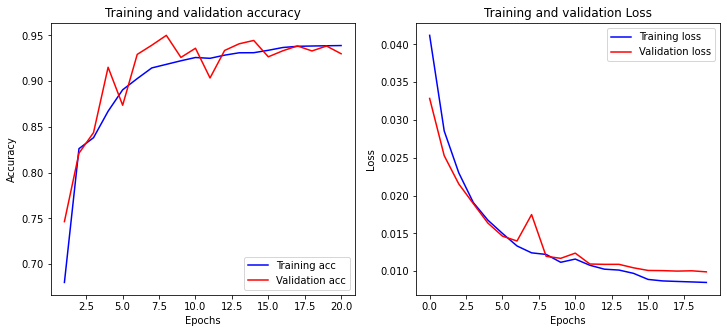

In [13]:
plot_acc_epoch(acc_hist,loss_hist)

<br>
<br>
<br>
<br>
<br>

### Prediction on Dataset

In [14]:
def load_data_synth(path_dataset, name_file, size_vlm):
    ''' Load synthetic seismic sub-volume from a binary file'''
    path_seis = os.path.join(path_dataset, 'seis', name_file)
    path_fault = os.path.join(path_dataset, 'fault', name_file)
    path_pred = os.path.join(path_dataset, 'pred', name_file)
    seis_vlm = np.fromfile(path_seis,dtype=np.single)
    fault_vlm = np.fromfile(path_fault,dtype=np.single)
    pred_vlm = np.fromfile(path_pred,dtype=np.single)
    seis_vlm = np.reshape(seis_vlm, size_vlm)
    fault_vlm = np.reshape(fault_vlm, size_vlm)
    pred_vlm = np.reshape(pred_vlm, size_vlm)
    return seis_vlm, fault_vlm, pred_vlm

In [15]:
def pred_subvlms(path_dataset, model, transform=None, patch_size=128):
    ''' Predict fault probability for a single seismic sub-volume '''
    size_vlm=np.array([1,1,1])*patch_size  
    path_seis = os.path.join(path_dataset, 'seis')
    path_pred = os.path.join(path_dataset, 'pred')
    if not os.path.exists(path_pred):
        os.makedirs(path_pred)

    for file in tqdm(os.listdir(path_seis)):
        if file.endswith('.dat'):
            path_read = os.path.join(path_seis, file)
            path_write = os.path.join(path_pred, file)
            seis_vlm = np.fromfile(path_read,dtype=np.single)
            seis_vlm = torch.as_tensor(np.reshape(seis_vlm,[*size_vlm]))
            if transform:                
                output = transform(seis_vlm).reshape((1,1,*size_vlm)).cuda()
            else:
                output = seis_vlm.reshape((1,1,*size_vlm)).cuda()
            pred_vlm = torch.sigmoid(model(output)).detach().cpu().numpy()
            fs = open(path_write, 'bw')
            pred_vlm.flatten().astype('float32').tofile(fs, format='%.4f')
            fs.close()

In [16]:
def show_image_synth(seis_slice, fault_slice, pred_slice, title, threshold):
    ''' Show fault prediction result on synthetic data for validation '''
    fig, axes = plt.subplots(1,3,figsize=(14,5))
    for i,ax in enumerate(axes.flat):
        plt.axes(ax)
        plt.imshow(seis_slice.T,cmap=plt.cm.gray_r)
        if  i == 0:
            plt.title('Seismic')
        elif i == 1:
            plt.imshow(create_img_alpha(pred_slice.T,threshold), alpha=0.5)
            plt.title('Fault Probability')            
        elif i == 2: 
            plt.imshow(create_img_alpha(fault_slice.T), alpha=0.5)
            plt.title('True Mask')
        plt.tick_params(axis='both',which='both',
                        bottom=False,left=False,labelleft=False,labelbottom=False)
    plt.text(-145,140,title,fontsize=14)
    plt.show()

In [17]:
def vlm_slicer(seis_vlms,pred_vlms,fault_vlms,idx_vlm=0,idx_slice=0,flag_slice=0):
    ''' Slice a seismic sub-volume for display '''
    seis_vlms = seis_vlms.copy()
    pred_vlms = pred_vlms.copy()
    fault_vlms = fault_vlms.copy()
    seis_vlm = seis_vlms[idx_vlm,...].copy()
    fault_vlm = fault_vlms[idx_vlm,...].copy()
    pred_vlm = pred_vlms[idx_vlm,...].copy()
    if   flag_slice == 0:
        seis_slice = seis_vlm[:,:,idx_slice]
        fault_slice = fault_vlm[:,:,idx_slice]
        pred_slice = pred_vlm[:,:,idx_slice]
        prefix = 'z-slice'
    elif flag_slice == 1:
        seis_slice = seis_vlm[:,idx_slice,:]
        fault_slice = fault_vlm[:,idx_slice,:]
        pred_slice = pred_vlm[:,idx_slice,:]
        prefix = 'y-slice'
    elif flag_slice == 2:
        seis_slice = seis_vlm[idx_slice,:,:]
        fault_slice = fault_vlm[idx_slice,:,:]
        pred_slice = pred_vlm[idx_slice,:,:]
        prefix = 'x-slice'
    title = 'Test Volume ID: ' + str(idx_vlm) + ', ' + prefix + ': ' + str(idx_slice)
    return seis_slice, fault_slice, pred_slice, title

In [18]:
def create_img_alpha(img_input,threshold=0.5):
    ''' Overlay a translucent fault image on a seismic image '''
    img_alpha = np.zeros([np.shape(img_input)[0], np.shape(img_input)[1],4])
    img_input[img_input < threshold] = 0
    img_alpha[:,:,0] = 1 # Yellow: (1,1,0), Red: (1,0,0)
    img_alpha[:,:,1] = 0
    img_alpha[:,:,2] = 0
    img_alpha[...,-1] = img_input
    return img_alpha

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.99it/s]


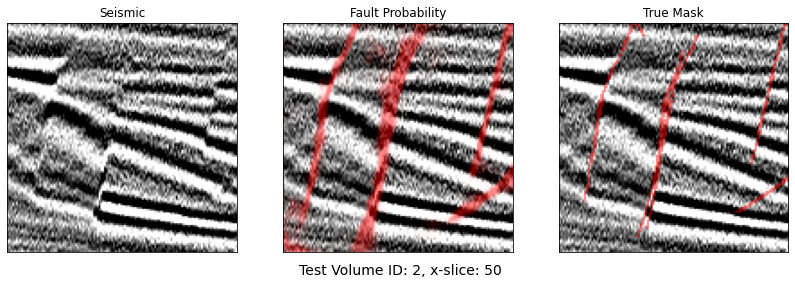

In [19]:
name_subset = ['train','validation']
path_dataset_tr  = os.path.join(path_home,'dataset',name_dataset,name_subset[0])
path_dataset_val = os.path.join(path_home,'dataset',name_dataset,name_subset[1])

''' Synthetic Data Application '''
pred_subvlms(path_dataset_tr,  model, transform=transform) # Training Data
pred_subvlms(path_dataset_val, model, transform=transform) # Validation Data

seis_vlms = np.zeros([num_data_val] + [patch_size]*3)
fault_vlms = np.zeros_like(seis_vlms)
pred_vlms = np.zeros_like(seis_vlms)
for i in range(num_data_val):
    filename = str(i) + '.dat'
    seis_vlms[i,...], fault_vlms[i,...], pred_vlms[i,...] = \
        load_data_synth(path_dataset_val,filename,tuple([patch_size]*3))
    
seis_slice, fault_slice, pred_slice, title = \
    vlm_slicer(seis_vlms,pred_vlms,fault_vlms,idx_vlm=2,idx_slice=50,flag_slice=2)
show_image_synth(seis_slice, fault_slice, pred_slice, title, threshold=0)

### Application to Field Data

In [20]:
def dataload_segy(path_seis,size_vlm,idx0_vlm):
    ''' This function loads a segy file and quary a subvolume defined by size_vlm and idx0_vlm '''
    file_segy = _read_segy(path_seis).traces
    traces = np.stack([t.data for t in file_segy])
    inlines = np.stack([t.header.for_3d_poststack_data_this_field_is_for_in_line_number for t in file_segy])
    xlines = np.stack([t.header.for_3d_poststack_data_this_field_is_for_cross_line_number for t in file_segy])
    idx_inline = inlines - np.min(inlines)
    idx_xline = xlines - np.min(xlines)
    num_traces = len(traces)
    num_inline = len(np.unique(inlines))
    num_xline = len(np.unique(xlines))
    num_sample = len(file_segy[0].data)
    seis_vlm = np.zeros([num_inline, num_xline, num_sample])
    for i in range(num_traces):
        seis_vlm[idx_inline[i],idx_xline[i],:] = traces[i]
    seis_vlm = seis_vlm[idx0_vlm[0]:idx0_vlm[0]+size_vlm[0],
                        idx0_vlm[1]:idx0_vlm[1]+size_vlm[1],
                        idx0_vlm[2]:idx0_vlm[2]+size_vlm[2]]
    return seis_vlm

In [21]:
def getMask(os,size_subvlm):
    ''' Set gaussian weights in the overlap bounaries '''
    n1, n2, n3 = size_subvlm[0],size_subvlm[1],size_subvlm[2]
    sc = np.zeros(size_subvlm,dtype=np.single)
    sc = sc+1
    sp = np.zeros((os),dtype=np.single)
    sig = os/4
    sig = 0.5/(sig*sig)
    for ks in range(os):
        ds = ks-os+1
        sp[ks] = np.exp(-ds*ds*sig)

    for k1 in range(os):
        for k2 in range(n2):
            for k3 in range(n3):
                sc[k1][k2][k3]=sp[k1]
                sc[n1-k1-1][k2][k3]=sp[k1]
    for k1 in range(n1):
        for k2 in range(os):
            for k3 in range(n3):
                sc[k1][k2][k3]=sp[k2]
                sc[k1][n2-k2-1][k3]=sp[k2]
    for k1 in range(n1):
        for k2 in range(n2):
            for k3 in range(os):
                sc[k1][k2][k3]=sp[k3]
                sc[k1][k2][n3-k3-1]=sp[k3]
    return sc

In [22]:
def apply_trained_net(model,seis_vlm,size_subvlm,size_vlm, transform=None):
    '''
    a 3d array of gx[m1][m2][m3], please make sure the dimensions are correct
    we strongly suggest to gain the seismic image before input it to the faultSeg
    '''
    size_vlm = np.shape(seis_vlm)
    n1, n2, n3 = size_subvlm[0],size_subvlm[1],size_subvlm[2]
    m1, m2, m3 = size_vlm[0],size_vlm[1],size_vlm[2]

    stdizer = lambda x: (x - np.mean(x)) / np.std(x)    
    os = 12 #overlap width
    c1 = np.round((m1+os)/(n1-os)+0.5)
    c2 = np.round((m2+os)/(n2-os)+0.5)
    c3 = np.round((m3+os)/(n3-os)+0.5)
    c1 = int(c1)
    c2 = int(c2)
    c3 = int(c3)
    p1 = (n1-os)*c1+os
    p2 = (n2-os)*c2+os
    p3 = (n3-os)*c3+os
    gx = np.reshape(seis_vlm,(m1,m2,m3))
    gp = np.zeros((p1,p2,p3),dtype=np.single)
    gy = np.zeros((p1,p2,p3),dtype=np.single)
    mk = np.zeros((p1,p2,p3),dtype=np.single)
    gs = np.zeros((1,1,*size_subvlm),dtype=np.single)
    gp[0:m1,0:m2,0:m3] = gx
    sc = getMask(os,size_subvlm)
    for k1 in range(c1):
        for k2 in range(c2):
            for k3 in range(c3):
                b1 = k1*n1-k1*os
                e1 = b1+n1
                b2 = k2*n2-k2*os
                e2 = b2+n2
                b3 = k3*n3-k3*os
                e3 = b3+n3
                gs[0,0,:,:,:]=gp[b1:e1,b2:e2,b3:e3]
                gs = stdizer(gs)
                Y = predict(model, gs, transform=transform)                
                Y = np.array(Y)
                gy[b1:e1,b2:e2,b3:e3] = gy[b1:e1,b2:e2,b3:e3]+Y[0,0,:,:,:]*sc
                mk[b1:e1,b2:e2,b3:e3] = mk[b1:e1,b2:e2,b3:e3]+sc
    gy = gy/mk
    pred_vlm = gy[0:m1,0:m2,0:m3]
    return pred_vlm

In [23]:
def predict(model, inputs, transform=None, size_vlm=tuple([128]*3)):
    inputs = torch.as_tensor(np.reshape(inputs, [*size_vlm]))
    if transform:
        output = transform(inputs).reshape((1,1,*size_vlm)).cuda()
    else:
        output = inputs.reshape((1,1,*size_vlm)).cuda()
    pred_vlm = torch.sigmoid(model(output)).detach().cpu().numpy()
    return pred_vlm

In [24]:
def show_image_field_data(seis_vlm, pred_vlm, title, idx_slice, threshold=0.5, flag_slice=0):
    ''' Show fault prediction result on field data '''
    seis_vlm = seis_vlm.copy()
    pred_vlm = pred_vlm.copy()
    if   flag_slice == 0:
        seis_slice = seis_vlm[:,:,idx_slice]
        pred_slice = pred_vlm[:,:,idx_slice]
        prefix = 'z-slice'
    elif flag_slice == 1:
        seis_slice = seis_vlm[:,idx_slice,:]
        pred_slice = pred_vlm[:,idx_slice,:]
        prefix = 'y-slice'
    elif flag_slice == 2:
        seis_slice = seis_vlm[idx_slice,:,:]
        pred_slice = pred_vlm[idx_slice,:,:]
        prefix = 'x-slice'
        
    # Display images
    plt.figure(figsize=(14, 6))
    plt.imshow(seis_slice.T,cmap=plt.cm.gray_r,vmin=0.1, vmax=0.9,)
    img_alpha = create_img_alpha(pred_slice.T, threshold)
    plt.imshow(img_alpha, alpha=0.5)
    plt.tick_params(axis='both',which='both',
                    bottom=False,left=False,labelleft=False,labelbottom=False)
    plt.title('F3 Block, ' + prefix + ': ' +str(idx_slice))
    plt.show()

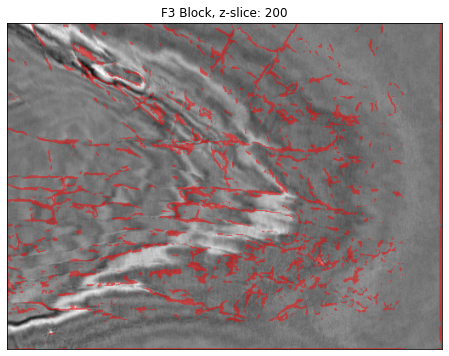

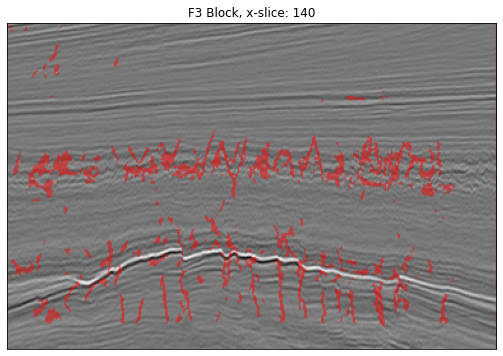

In [25]:
path_seis = './F3_seismic.sgy'
size_data = tuple(patch_size*np.array([4,3,2]))
idx0_subvlm = (0,0,200)

''' Field Data Application '''
standardizer = lambda x: (x-np.min(x))/(np.max(x)-np.min(x))
seis_vlm_F3 = standardizer(dataload_segy(path_seis, size_data, idx0_subvlm))
pred_vlm_F3 = apply_trained_net(model,seis_vlm_F3,tuple([patch_size]*3),size_data, transform)

title = 'F3'
show_image_field_data(seis_vlm_F3, pred_vlm_F3, title, idx_slice=200, threshold=0.9, flag_slice=0)
show_image_field_data(seis_vlm_F3, pred_vlm_F3, title, idx_slice=140, threshold=0.9, flag_slice=2)

In [ ]:
""" PyTorch Lightning Version """

class UNet(pl.LightningModule):
    def __init__(self, trainset, testset, num_batch):
        super().__init__()
        self.dec1 = self.Conv3d_x2(1,    2**4)
        self.dec2 = self.Conv3d_x2(2**4, 2**5)
        self.dec3 = self.Conv3d_x2(2**5, 2**6)
        self.cent = self.Conv3d_x2(2**6, 2**9)
        self.enc3 = self.Conv3d_x2(2**9 + 2**6, 2**6)
        self.enc2 = self.Conv3d_x2(2**6 + 2**5, 2**5)
        self.enc1 = self.Conv3d_x2(2**5 + 2**4, 2**4)
        self.fin = nn.Conv3d(2**4, 1, 1)
        torch.nn.init.kaiming_normal_(self.fin.weight)
        self.maxpool = nn.MaxPool3d(2, stride=2, ceil_mode=True)
        self.upsample = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)        
        self.trainset = trainset
        self.testset = testset
        self.num_batch = num_batch
        self.epoch = 0
        
    def forward(self, x):
        dec1 = self.dec1(x)
        dec2 = self.dec2(self.maxpool(dec1))
        dec3 = self.dec3(self.maxpool(dec2))
        cent = self.cent(self.maxpool(dec3))
        enc3 = self.enc3(torch.cat([self.upsample(cent), dec3], dim=1))
        enc2 = self.enc2(torch.cat([self.upsample(enc3), dec2], dim=1))
        enc1 = self.enc1(torch.cat([self.upsample(enc2), dec1], dim=1))
        out  = self.fin(enc1)
        return out

    def Conv3d_x2(self, in_channels, out_channels):
        conv3d_x2 = nn.Sequential(
                    nn.Conv3d(in_channels, out_channels, 3, padding=1),
                    nn.ReLU(inplace=True),
                    nn.Conv3d(out_channels , out_channels, 3, padding=1),
                    nn.ReLU(inplace=True),
                    )
        conv3d_x2.apply(self.init_weight_bias)     
        return conv3d_x2
    
    def init_weight_bias(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv3d') == 0:
            torch.nn.init.kaiming_normal_(m.weight)
            
    def configure_optimizers(self):
        optimizer = Adam(model.parameters(), lr=1e-3)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        inputs, labels = self.data_augment(inputs, labels, num_batch=1)
        outputs = self.forward(inputs)
        loss = self.calc_loss(labels, outputs)
        acc = self.binary_acc(labels, outputs)
        logs = {'loss': loss, 'acc': acc}
        return {'loss': loss, 'acc': acc, 'log': logs}

    def training_epoch_end(self, outputs):
        self.epoch += 1        
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        avg_acc  = torch.stack([x['acc'] for x in outputs]).mean()
        print('Training (Epoch: ' + str(self.epoch) + ')')
        print('Loss: {:.4f}, Acc: {:.4f}'.format(avg_loss, avg_acc))
        logs = {'loss': avg_loss, 'acc': avg_acc}
        return {'loss': avg_loss, 'acc': avg_acc, 'log': logs}
    
    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        inputs = torch.reshape(inputs, (1,1,128,128,128))
        labels = torch.reshape(labels, (1,1,128,128,128))        
        outputs = self.forward(inputs)
        loss = self.calc_loss(labels, outputs)
        acc = self.binary_acc(labels, outputs)
        logs = {'loss': loss, 'acc': acc}
        return {'val_loss': loss, 'val_acc': acc, 'log': logs}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc  = torch.stack([x['val_acc'] for x in outputs]).mean()        
        logs = {'val_loss': avg_loss, 'val_acc': avg_acc}
        
        if self.epoch > 0:
            print('Validation (Epoch: ' + str(self.epoch) + ')')
            print('Loss: {:.4f}, Acc: {:.4f}'.format(avg_loss, avg_acc))
        return {'val_loss': avg_loss, 'log': logs}
    
    def calc_loss(self, labels, outputs):
        # Balanced Cross-Entropy
        count_pos = labels.sum()        # Fault
        count_neg = (1 - labels).sum()  # Non-fault
        beta = torch.as_tensor(count_neg / (count_neg + count_pos))
        pos_weight = torch.where(labels==1, beta / (1 - beta), torch.ones(1).cuda())
        loss = F.binary_cross_entropy_with_logits(outputs, labels, pos_weight=pos_weight)
        return loss * (1 - beta)
    
    def binary_acc(self, labels, outputs):
        y_pred_tag = torch.round(torch.sigmoid(outputs))
        correct_results_sum = torch.eq(y_pred_tag, labels).sum().float()
        acc = correct_results_sum / labels.shape.numel()
        return acc

    def data_augment(self, inputs, labels, num_batch, num_ch=1, num_aug=4, dim=(128,128,128)):
        X = np.zeros([num_batch*num_aug, num_ch, *dim])
        Y = np.zeros([num_batch*num_aug, num_ch, *dim])

        for i in range(num_batch):
            for j in range(num_aug):
                X[num_aug*i+j,] = np.rot90(inputs[i,].cpu(),j,(0,1))
                Y[num_aug*i+j,] = np.rot90(labels[i,].cpu(),j,(0,1))

        inputs_aug = torch.from_numpy(X).float().reshape((num_batch*num_aug, num_ch, *dim))
        labels_aug = torch.from_numpy(Y).float().reshape((num_batch*num_aug, num_ch, *dim))
        return inputs_aug.cuda(), labels_aug.cuda()

    @pl.data_loader
    def train_dataloader(self):
        return DataLoader(self.trainset, batch_size=self.num_batch, shuffle=True)

    @pl.data_loader
    def val_dataloader(self):
        return DataLoader(self.testset, batch_size=self.num_batch, shuffle=False)

model = UNet(trainset, testset, num_batch)
trainer = pl.Trainer(max_epochs=num_epoch, gpus=1)
trainer.fit(model)